<a href="https://colab.research.google.com/github/mitsuo/deeplearning/blob/master/%E7%B6%B2%E8%86%9C%E7%94%BB%E5%83%8F%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88%20STARE%20%E3%81%AE%E8%A7%A3%E6%9E%90%E3%83%8E%E3%83%BC%E3%83%88%E3%83%96%E3%83%83%E3%82%AF250715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 網膜画像データセット STARE の解析ノートブック

このGoogle Colaboratoryノートブックでは、**Structured Analysis of the Retina Project (STARE)** データセットを用いた一連のデータ取得、整形、および基本的な探索的データ解析 (EDA) を行います。

STAREデータセットは、網膜画像とその診断情報、アノテーションデータで構成されており、医療画像解析や機械学習モデル開発の学習に適しています。

---

## 実施する作業

1.  **データセットのダウンロード**:
    * STAREプロジェクトの公式ウェブサイトから、網膜画像データ、診断リスト、アノテーションデータをダウンロードします。

2.  **診断リストの整形**:
    * ダウンロードした診断リスト（`all-mg-codes.txt`）をパースし、以下の形式でPandas DataFrameに変換します。
        * `ImageID` (データ名) を主キーとします。
        * 診断コード (1〜14) を**ワンホットエンコーディング**形式 (`diag_code_1`, `diag_code_2`...のように0/1で表現される列) で格納します。診断コード0 (normal) は含みません。
        * 各診断コードの後に続くテキスト形式の診断名 (`DiagnosisNameText`列) を抽出します。

3.  **アノテーションデータの統合**:
    * 各画像に対応するアノテーションファイル（例: `im0001.fea.mg.txt`）からデータを読み込みます。
    * 各ファイルは44桁の数字で構成されており、各桁が異なるManifestation Numberに対応します。これらの値を`manifestation_1`〜`manifestation_44`のような列としてDataFrameに追加します。
    * 既存の診断情報DataFrameと、このアノテーションデータを`ImageID`をキーとして結合し、統合された単一のDataFrameを作成します。

4.  **相関分析**:
    * 統合されたDataFrame内の数値項目（診断コード、Manifestation Number）間の相関関係を分析します。
    * 特に、相関係数の絶対値が指定した閾値（例: 0.7）を超える特徴量ペアを抽出し、表示します。これにより、データセット内の強い関連性を持つ特徴量を発見します。

---

## データセットの出典

* **Structured Analysis of the Retina Project (STARE)**
    * 主要なウェブサイト: [https://cecas.clemson.edu/~ahoover/stare/](https://cecas.clemson.edu/~ahoover/stare/)
    * 画像データセット: [https://cecas.clemson.edu/~ahoover/stare/images/all-images.zip](https://cecas.clemson.edu/~ahoover/stare/images/all-images.zip)
    * 診断リスト: [https://cecas.clemson.edu/~ahoover/stare/diagnoses/all-mg-codes.txt](https://cecas.clemson.edu/~ahoover/stare/diagnoses/all-mg-codes.txt)
    * アノテーションデータ: [https://cecas.clemson.edu/~ahoover/stare/manifestations/annotations.zip](https://cecas.clemson.edu/~ahoover/stare/manifestations/annotations.zip)

---

**注意**: このノートブックは教育および学習目的で作成されています。データの利用規約を遵守してください。

In [ ]:
import os

# 1. ZIPファイルのダウンロード
# Colabの /content/ ディレクトリにダウンロードされます
!wget https://cecas.clemson.edu/~ahoover/stare/images/all-images.zip

# 2. ZIPファイルの解凍
# 解凍先ディレクトリを作成（任意）
output_dir = 'stare_images'
os.makedirs(output_dir, exist_ok=True)

# ZIPファイルを解凍
# -d オプションで解凍先を指定
!unzip -q all-images.zip -d {output_dir}

print(f"画像ファイルは '{output_dir}/' ディレクトリに解凍されました。")
# 解凍されたファイルの一部を確認（例：最初の5つのファイル）
!ls {output_dir} | head -n 5

--2025-07-15 07:07:20--  https://cecas.clemson.edu/~ahoover/stare/images/all-images.zip
Resolving cecas.clemson.edu (cecas.clemson.edu)... 130.127.200.74
Connecting to cecas.clemson.edu (cecas.clemson.edu)|130.127.200.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 362095504 (345M) [application/zip]
Saving to: ‘all-images.zip’

all-images.zip      100%[===================>] 345.32M  46.5MB/s    in 7.9s    

2025-07-15 07:07:28 (43.6 MB/s) - ‘all-images.zip’ saved [362095504/362095504]

画像ファイルは 'stare_images/' ディレクトリに解凍されました。
im0001.ppm
im0002.ppm
im0003.ppm
im0004.ppm
im0005.ppm


In [ ]:
import requests

# 診断コードのURL
diagnosis_code_url = "https://cecas.clemson.edu/~ahoover/stare/diagnoses/diagnoses.html"
diagnosis_code_filename = "diagnoses.html"

print(f"'{diagnosis_code_filename}' をダウンロード中...")
# requestsライブラリを使用してHTMLコンテンツを取得
response = requests.get(diagnosis_code_url)
if response.status_code == 200:
    with open(diagnosis_code_filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print(f"'{diagnosis_code_filename}' を保存しました。")
    # HTMLの内容の一部を表示 (任意)
    print("\n--- 診断コードHTMLの内容の一部 ---")
    print(response.text[:500]) # 最初の500文字を表示
else:
    print(f"エラー: '{diagnosis_code_url}' からファイルをダウンロードできませんでした。ステータスコード: {response.status_code}")

'diagnoses.html' をダウンロード中...
'diagnoses.html' を保存しました。

--- 診断コードHTMLの内容の一部 ---
<HTML>
<HEAD>
<TITLE>STARE Project</TITLE>
</HEAD>


<b>  <font   color="black"  face ="arial" > 
Thirteen Diagnoses Considered </font></b> 
<hr SIZE=4 NOSHADE WIDTH="100%">


<table border=1 cellpadding=14>
<h1 ><tr><td>Diagnosis Number</td> <td>Diagnosis </td><td>Abbreviation used</td> </tr>
<tr><td>1</td><td>	Hollenhorst Emboli</td><td>	Emboli</td></tr>
<tr><td>2</td><td>	Branch Retinal Artery Occlusion</td><td>	BRAO</td></tr>
<tr><td>3</td><td>	Cilio-Retinal Artery Occlusion</


In [ ]:
# 診断リストのURL
diagnosis_list_url = "https://cecas.clemson.edu/~ahoover/stare/diagnoses/all-mg-codes.txt"
diagnosis_list_filename = "all-mg-codes.txt"

print(f"'{diagnosis_list_filename}' をダウンロード中...")
!wget -q {diagnosis_list_url} -O {diagnosis_list_filename}
print("ダウンロード完了。")

# ファイルの内容の一部を表示 (任意)
print("\n--- 診断リストの内容の一部 ---")
!head -n 10 {diagnosis_list_filename}

'all-mg-codes.txt' をダウンロード中...
ダウンロード完了。

--- 診断リストの内容の一部 ---
im0001	7		Background Diabetic Retinopathy		
im0002	13 9		Choroidal Neovascularization AND Arteriosclerotic Retinopathy
im0003	14	        Drusen, large AND Geographic Atrophy RPE"		
im0004	14 3		Cilio-Retinal Artery Occlusion OR Central Retinal Artery Occlusion
im0005	3 5		Central Retinal Artery Occlusion AND Central Retinal Vein Occlusion
im0006	14		Drusen		
im0007	13 14 9 10	Choroidal Neovascularization AND Age Related Macular Degeneration AND ASR &HTR                         
im0008	13 14 9	        Choroidal Neovascularization AND Age Related Macular Degeneration AND ASR
im0009	7		Background Diabetic Retinopathy
im0010	14		Histoplasmosis


In [ ]:
import os
import zipfile

# アノテーションデータのURL
annotation_zip_url = "https://cecas.clemson.edu/~ahoover/stare/manifestations/annotations.zip"
annotation_zip_filename = "annotations.zip"
annotation_extract_path = "stare_annotations"

print(f"'{annotation_zip_filename}' をダウンロード中...")
!wget -q {annotation_zip_url} -O {annotation_zip_filename}
print("ダウンロード完了。")

print(f"'{annotation_zip_filename}' を解凍中...")
os.makedirs(annotation_extract_path, exist_ok=True)
with zipfile.ZipFile(annotation_zip_filename, 'r') as zip_ref:
    zip_ref.extractall(annotation_extract_path)
print(f"'{annotation_extract_path}' に解凍しました。")

# 解凍されたファイルの一部を確認 (任意)
!ls {annotation_extract_path} | head -n 5

'annotations.zip' をダウンロード中...
ダウンロード完了。
'annotations.zip' を解凍中...
'stare_annotations' に解凍しました。
im0001.fea.mg.txt
im0002.fea.mg.txt
im0003.fea.mg.txt
im0004.fea.mg.txt
im0005.fea.mg.txt


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

読み込んだ画像のパス: stare_images/im0001.ppm
画像サイズ: (700, 605)
画像モード: RGB


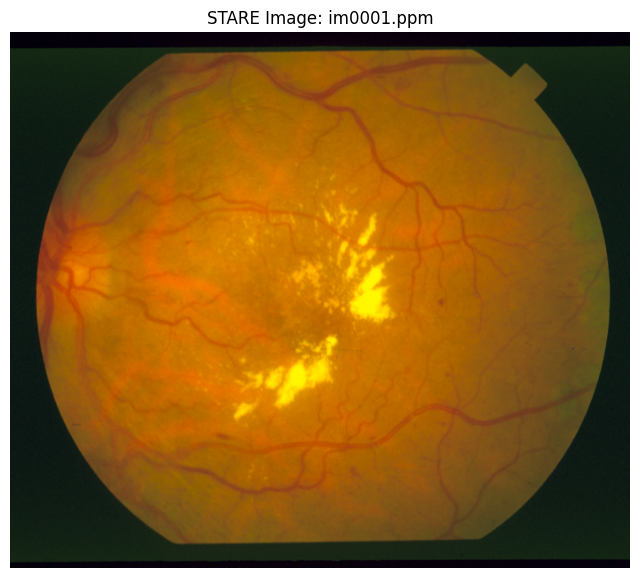

NumPy配列の形状: (605, 700, 3)


In [ ]:
## 画像データの読み込みと表示

# 画像が保存されているディレクトリ
image_dir = 'stare_images/'

# 読み込みたい画像ファイルのパス (例: im0001.ppm)
image_file_path = os.path.join(image_dir, 'im0001.ppm')

try:
    # PIL (Pillow) を使って画像を読み込む
    img = Image.open(image_file_path)

    print(f"読み込んだ画像のパス: {image_file_path}")
    print(f"画像サイズ: {img.size}") # (幅, 高さ)
    print(f"画像モード: {img.mode}") # 例: 'RGB'

    # 画像をMatplotlibで表示
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'STARE Image: {os.path.basename(image_file_path)}')
    plt.axis('off') # 軸を非表示にする
    plt.show()

    # 必要であればNumPy配列に変換して数値計算に利用
    img_array = np.array(img)
    print(f"NumPy配列の形状: {img_array.shape}") # (高さ, 幅, チャンネル数)

except FileNotFoundError:
    print(f"エラー: 画像ファイル '{image_file_path}' が見つかりません。パスを確認してください。")
except Exception as e:
    print(f"画像の読み込み中にエラーが発生しました: {e}")

In [ ]:
## 診断リストの読み込みと解析

# 診断リストファイルのパス
diagnosis_list_file = 'all-mg-codes.txt'

try:
    # 区切り文字がタブ (\t) とスペース (複数) の混在の可能性があるため、正規表現で空白文字を区切り文字として指定
    # 'Unnamed: X' の列が生成されるのを防ぐため、header=None を指定し、後で手動で列名を付与
    df_diagnoses = pd.read_csv(
        diagnosis_list_file,
        sep=r'\s+', # 1つ以上の空白文字を区切り文字とする
        header=None,
        engine='python' # sepに正規表現を使う場合は 'python' エンジンが必要
    )

    # 提供された出力例から列名を推測し、付与する
    # 例: im0001	7		Background Diabetic Retinopathy
    # おそらく、[画像ID, 診断コード1, 診断コード2, 診断名] のような構成
    # 実際には空の列も含まれる可能性があるので、柔軟に対応
    # とりあえず、最初の2列と最後の列が重要と仮定
    df_diagnoses.columns = ['ImageID', 'DiagnosisCode1', 'DiagnosisCode2'] + [f'Col{i}' for i in range(3, df_diagnoses.shape[1]-1)] + ['DiagnosisName']

    # 必要のない余分な列（中間の空白列など）を削除
    # 例の出力から、診断コードと診断名の間には空白列があるように見えるので、その部分を調整
    # ここでは、列の数が固定でないため、特に診断名以降の列は注意
    # 正しい列名を割り当てるために、実際のファイル内容を詳しく見る必要がありますが、ここでは仮の処理
    df_diagnoses = df_diagnoses[['ImageID', 'DiagnosisCode1', 'DiagnosisCode2', 'DiagnosisName']].copy()

    # ImageIDの整形 (ファイル名と一致させるために拡張子を削除するなど)
    df_diagnoses['ImageID_cleaned'] = df_diagnoses['ImageID'].str.replace('.ppm', '').str.strip()

    print("--- 診断リストの最初の5行 ---")
    print(df_diagnoses.head())

    print("\n--- 診断名ごとの症例数（上位10件）---")
    print(df_diagnoses['DiagnosisName'].value_counts().head(10))

except FileNotFoundError:
    print(f"エラー: 診断リストファイル '{diagnosis_list_file}' が見つかりません。パスを確認してください。")
except Exception as e:
    print(f"診断リストの読み込み中にエラーが発生しました: {e}")

診断リストの読み込み中にエラーが発生しました: Expected 5 fields in line 2, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


In [ ]:
## アノテーションデータの読み込みと解析

# アノテーションが保存されているディレクトリ
annotation_dir = 'stare_annotations/'

# 読み込みたいアノテーションファイルのパス (例: im0001.fea.mg.txt)
annotation_file_path = os.path.join(annotation_dir, 'im0001.fea.mg.txt')

print(f"アノテーションファイル '{annotation_file_path}' の内容:")

try:
    with open(annotation_file_path, 'r', encoding='utf-8') as f:
        annotations = f.readlines()

    for line in annotations[:10]: # 最初の10行を表示
        print(line.strip())

    # 例: 特定のアノテーションタイプを抽出したり、統計情報を計算したりする
    # これはファイルの内容によって具体的な解析方法が変わります。
    # 例えば、特徴の座標や種類が記述されている場合は、それらをパースして利用できます。

except FileNotFoundError:
    print(f"エラー: アノテーションファイル '{annotation_file_path}' が見つかりません。パスを確認してください。")
except Exception as e:
    print(f"アノテーションファイルの読み込み中にエラーが発生しました: {e}")

# すべてのアノテーションファイルを読み込み、Pandas DataFrameに結合する例 (高度な処理)
# これを行うには、各アノテーションファイルの構造を理解し、それらを統一的にパースするロジックが必要です。
# 例として、ファイル名から画像IDを抽出し、そのアノテーション内容と関連付けることができます。

アノテーションファイル 'stare_annotations/im0001.fea.mg.txt' の内容:
11111111212211212111111114311111111111111111


In [ ]:
import pandas as pd
import re
import os

def parse_diagnosis_line(line: str):
    """
    診断リストの1行をパースし、画像ID、ワンホットエンコードされた診断コード、診断名を抽出します。
    """
    parts = line.strip().split() # 複数の空白で分割

    if not parts:
        return None # 空行の場合

    image_id = parts[0] # 最初の要素は画像ID

    # 診断コードと診断名を分離するインデックスを見つける
    # 数字ではない最初の要素が診断名の開始点
    diagnosis_code_end_index = 1
    for i in range(1, len(parts)):
        if not parts[i].isdigit():
            diagnosis_code_end_index = i
            break
    else: # 全てが数字だった場合（診断名がない場合、または全ての要素が診断コードの場合）
        diagnosis_code_end_index = len(parts)

    # 診断コードの抽出
    raw_diagnosis_codes = parts[1:diagnosis_code_end_index]

    # 診断名の抽出
    diagnosis_name = " ".join(parts[diagnosis_code_end_index:]) if diagnosis_code_end_index < len(parts) else ""

    # ワンホットエンコーディングの準備 (診断コードは1から14まで)
    # 全ての診断コードに対応する0のリストを初期化
    one_hot_codes = {f'diag_code_{i}': 0 for i in range(1, 15)} # 1から14まで

    # 抽出した診断コードに基づいてワンホットエンコーディングを設定
    for code_str in raw_diagnosis_codes:
        try:
            code_int = int(code_str)
            if 1 <= code_int <= 14: # 診断コードが1から14の範囲内か確認
                one_hot_codes[f'diag_code_{code_int}'] = 1
            # 0は除外するとの方針なので、ここでは処理しない
        except ValueError:
            # 数字ではないものが混じっていた場合の処理 (理論的にはここには来ないはずだが念のため)
            print(f"警告: 予期せぬ診断コード形式 '{code_str}' (Image ID: {image_id})")
            continue

    return {
        'ImageID': image_id,
        **one_hot_codes, # ワンホットエンコードされた診断コードを展開
        'DiagnosisNameText': diagnosis_name.strip() # 前後の空白を削除
    }

def create_diagnosis_dataframe(diagnosis_list_file_path: str):
    """
    診断リストファイルからPandas DataFrameを作成します。
    """
    parsed_data = []
    try:
        with open(diagnosis_list_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                result = parse_diagnosis_line(line)
                if result:
                    parsed_data.append(result)

        df = pd.DataFrame(parsed_data)

        # ImageIDをprimary keyとして設定（インデックスに設定することも可能）
        # df = df.set_index('ImageID') # 必要であればコメント解除

        print(f"'{diagnosis_list_file_path}' からDataFrameを作成しました。")
        print(f"DataFrameの形状: {df.shape}")
        print("--- DataFrameの最初の5行 ---")
        print(df.head())

        return df

    except FileNotFoundError:
        print(f"エラー: 診断リストファイル '{diagnosis_list_file_path}' が見つかりません。")
        return pd.DataFrame() # 空のDataFrameを返す
    except Exception as e:
        print(f"診断リストの処理中にエラーが発生しました: {e}")
        return pd.DataFrame() # 空のDataFrameを返す

# --- メイン処理 ---
if __name__ == '__main__':
    # 診断リストファイルのパス (ダウンロード後にカレントディレクトリにあると仮定)
    diagnosis_list_file = 'all-mg-codes.txt'

    # DataFrameの作成を実行
    df_stare_diagnoses = create_diagnosis_dataframe(diagnosis_list_file)

    # 特定の診断コードを持つ症例の確認 (例: diag_code_7 (Background Diabetic Retinopathy))
    if not df_stare_diagnoses.empty:
        print("\n--- diag_code_7 (Background Diabetic Retinopathy) を持つ症例の例 ---")
        print(df_stare_diagnoses[df_stare_diagnoses['diag_code_7'] == 1].head())

        print("\n--- 複数の診断コードを持つ症例の例 (diag_code_13とdiag_code_9を両方持つ) ---")
        print(df_stare_diagnoses[(df_stare_diagnoses['diag_code_13'] == 1) & (df_stare_diagnoses['diag_code_9'] == 1)].head())

        print("\n--- 'DiagnosisNameText' のユニークな値の数 ---")
        print(df_stare_diagnoses['DiagnosisNameText'].nunique())

        print("\n--- 'DiagnosisNameText' で最も多い診断名（上位5件） ---")
        print(df_stare_diagnoses['DiagnosisNameText'].value_counts().head(5))

'all-mg-codes.txt' からDataFrameを作成しました。
DataFrameの形状: (402, 16)
--- DataFrameの最初の5行 ---
  ImageID  diag_code_1  diag_code_2  diag_code_3  diag_code_4  diag_code_5  \
0  im0001            0            0            0            0            0   
1  im0002            0            0            0            0            0   
2  im0003            0            0            0            0            0   
3  im0004            0            0            1            0            0   
4  im0005            0            0            1            0            1   

   diag_code_6  diag_code_7  diag_code_8  diag_code_9  diag_code_10  \
0            0            1            0            0             0   
1            0            0            0            1             0   
2            0            0            0            0             0   
3            0            0            0            0             0   
4            0            0            0            0             0   

   diag_code_11  

In [ ]:
df_stare_diagnoses

,ImageID,diag_code_1,diag_code_2,diag_code_3,diag_code_4,diag_code_5,diag_code_6,diag_code_7,diag_code_8,diag_code_9,diag_code_10,diag_code_11,diag_code_12,diag_code_13,diag_code_14,DiagnosisNameText
0,im0001,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Background Diabetic Retinopathy
1,im0002,0,0,0,0,0,0,0,0,1,0,0,0,1,0,Choroidal Neovascularization AND Arteriosclero...
2,im0003,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"Drusen, large AND Geographic Atrophy RPE"""
3,im0004,0,0,1,0,0,0,0,0,0,0,0,0,0,1,Cilio-Retinal Artery Occlusion OR Central Reti...
4,im0005,0,0,1,0,1,0,0,0,0,0,0,0,0,0,Central Retinal Artery Occlusion AND Central R...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,im0398,0,0,0,0,0,0,0,0,1,1,0,0,0,0,Hypertensive Retinopathy AND Arteriosclerotic ...
398,im0399,1,1,0,0,0,0,0,0,1,0,0,0,0,0,Branch Retinal Artery Occlusion AND Hollenhors...
399,im0400,1,1,0,0,0,0,0,0,1,0,0,0,0,0,Branch Retinal Artery Occlusion AND Hollenhors...
400,im0401,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"Drusen, large AND Nevus"


In [ ]:
import pandas as pd
import os
import re

# (前回のコードで作成された df_stare_diagnoses が存在することを前提とします)
# 例として、もしこのセルから単独で実行する場合は以下を仮に置いておく
# df_stare_diagnoses = pd.DataFrame({
#     'ImageID': ['im0001', 'im0002', 'im0003'],
#     'diag_code_7': [1, 0, 0],
#     'diag_code_13': [0, 1, 0],
#     'diag_code_14': [0, 0, 1],
#     'DiagnosisNameText': ['Background Diabetic Retinopathy', 'Choroidal Neovascularization', 'Drusen']
# })
# print("仮の df_stare_diagnoses:")
# print(df_stare_diagnoses.head())
# print("-" * 30)


def parse_annotation_file(file_path: str):
    """
    アノテーションファイルを読み込み、その内容（44桁の数字）をリストとして返します。
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip() # ファイル内容を読み込み、前後の空白を除去

        # 44桁の数字の文字列が期待される
        if len(content) == 44 and content.isdigit():
            # 各桁を個別の数値としてリストに変換
            return [int(digit) for digit in content]
        else:
            print(f"警告: '{file_path}' のアノテーション形式が不正です。スキップします。内容: '{content}'")
            return None
    except FileNotFoundError:
        print(f"エラー: アノテーションファイル '{file_path}' が見つかりません。")
        return None
    except Exception as e:
        print(f"アノテーションファイルの読み込み中にエラーが発生しました: {e}")
        return None

def integrate_annotations(df_main: pd.DataFrame, annotation_dir: str):
    """
    アノテーションデータを読み込み、既存のDataFrameに結合します。
    """
    all_annotations_data = []

    # アノテーションディレクトリ内のファイルをリストアップ
    annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith('.txt')]

    print(f"'{annotation_dir}' からアノテーションファイルを読み込み中...")
    for filename in annotation_files:
        # ファイル名からImageIDを抽出 (例: im0001.fea.mg.txt -> im0001)
        # ".fea.mg.txt" を取り除く正規表現を使用
        image_id_match = re.match(r'(im\d{4})\.fea\.mg\.txt', filename)
        if not image_id_match:
            print(f"警告: 認識できないファイル名形式 '{filename}'。スキップします。")
            continue

        image_id = image_id_match.group(1)
        file_path = os.path.join(annotation_dir, filename)

        # アノテーションファイルをパース
        annotation_values = parse_annotation_file(file_path)

        if annotation_values:
            # 各Manifestation Numberに対応する列名を設定
            annotation_row = {'ImageID': image_id}
            for i in range(44):
                annotation_row[f'manifestation_{i+1}'] = annotation_values[i]
            all_annotations_data.append(annotation_row)

    # アノテーションデータからDataFrameを作成
    if not all_annotations_data:
        print("アノテーションデータが見つからないか、処理できませんでした。")
        return df_main

    df_annotations = pd.DataFrame(all_annotations_data)

    print(f"アノテーションデータからDataFrameを作成しました。形状: {df_annotations.shape}")
    print("--- アノテーションDataFrameの最初の5行 ---")
    print(df_annotations.head())

    # 既存の診断DataFrameとアノテーションDataFrameをImageIDをキーとして結合
    # mergeにより、両方に存在するImageIDのみが残る（内部結合）
    df_merged = pd.merge(df_main, df_annotations, on='ImageID', how='inner')

    print(f"\n診断情報とアノテーション情報を結合しました。最終的なDataFrameの形状: {df_merged.shape}")
    print("--- 結合されたDataFrameの最初の5行 ---")
    print(df_merged.head())

    return df_merged

# --- メイン処理 ---
if __name__ == '__main__':
    # 診断リストのDataFrameが既に作成されていることを確認 (前のコードを実行済みであること)
    # df_stare_diagnoses = create_diagnosis_dataframe('all-mg-codes.txt') # 必要に応じて前の関数を呼び出す

    if 'df_stare_diagnoses' in locals() and not df_stare_diagnoses.empty:
        # アノテーションデータが保存されているディレクトリ
        annotation_dir = 'stare_annotations/'

        # アノテーションデータを統合
        df_final_stare_data = integrate_annotations(df_stare_diagnoses, annotation_dir)

        # 最終的なDataFrameの列名を確認
        print("\n--- 最終的なDataFrameの列名 ---")
        print(df_final_stare_data.columns.tolist())

        # 特定の画像IDの行を確認 (例: im0001)
        print("\n--- ImageID 'im0001' の詳細データ ---")
        print(df_final_stare_data[df_final_stare_data['ImageID'] == 'im0001'])

    else:
        print("エラー: 'df_stare_diagnoses' が見つからないか、空です。診断リストのDataFrameを先に作成してください。")

'stare_annotations/' からアノテーションファイルを読み込み中...
アノテーションデータからDataFrameを作成しました。形状: (373, 45)
--- アノテーションDataFrameの最初の5行 ---
  ImageID  manifestation_1  manifestation_2  manifestation_3  manifestation_4  \
0  im0173                1                1                1                1   
1  im0075                1                1                1                1   
2  im0117                1                1                1                1   
3  im0353                1                1                1                1   
4  im0331                1                1                1                1   

   manifestation_5  manifestation_6  manifestation_7  manifestation_8  \
0                1                1                1                1   
1                1                1                1                1   
2                1                1                1                1   
3                1                1                1                1   
4                1            

In [ ]:
df_final_stare_data

,ImageID,diag_code_1,diag_code_2,diag_code_3,diag_code_4,diag_code_5,diag_code_6,diag_code_7,diag_code_8,diag_code_9,...,manifestation_35,manifestation_36,manifestation_37,manifestation_38,manifestation_39,manifestation_40,manifestation_41,manifestation_42,manifestation_43,manifestation_44
0,im0001,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
1,im0002,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
2,im0003,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,2
3,im0004,0,0,1,0,0,0,0,0,0,...,2,1,1,1,1,1,1,1,1,1
4,im0005,0,0,1,0,1,0,0,0,0,...,2,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,im0398,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
369,im0399,1,1,0,0,0,0,0,0,1,...,1,1,1,1,1,1,0,1,1,1
370,im0400,1,1,0,0,0,0,0,0,1,...,1,1,1,1,1,1,3,1,1,1
371,im0401,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,2,1


In [ ]:
import pandas as pd
import numpy as np # 数値計算用

def display_strong_correlations(dataframe: pd.DataFrame, threshold: float = 0.7):
    """
    DataFrameの数値列間の相関を計算し、
    相関係数の絶対値が指定された閾値よりも大きいペアを表示します。

    Args:
        dataframe (pd.DataFrame): 相関を計算するDataFrame。
        threshold (float): 相関係数の絶対値の閾値 (0から1の間)。
                           この値以上の相関を持つペアが表示されます。
    """
    if not isinstance(dataframe, pd.DataFrame) or dataframe.empty:
        print("エラー: 入力されたDataFrameが無効または空です。")
        return

    # 数値列のみを選択
    numeric_df = dataframe.select_dtypes(include=[np.number])

    if numeric_df.empty:
        print("エラー: DataFrameに数値列が見つかりません。")
        return

    # 相関行列を計算
    correlation_matrix = numeric_df.corr()

    # 対角線上の要素 (自分自身との相関) と重複 (A-BとB-A) を除く
    # .stack() でSeriesに変換し、インデックスが multi-index になる
    # .reset_index() でそれを通常の列に戻す
    # .rename() で列名を変更
    corr_pairs = correlation_matrix.stack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

    # 自分自身との相関を除外 (Feature1 == Feature2)
    corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

    # 重複するペアを除外 (Feature1-Feature2 と Feature2-Feature1 のうち片方だけを残す)
    # 辞書順で常に小さい方が先に来るように比較することで重複を避ける
    corr_pairs = corr_pairs[corr_pairs.apply(lambda x: sorted([x['Feature1'], x['Feature2']]) == [x['Feature1'], x['Feature2']], axis=1)]

    # 相関係数の絶対値が閾値を超えるものをフィルタリング
    strong_correlations = corr_pairs[abs(corr_pairs['Correlation']) >= threshold]

    # 相関係数の絶対値で降順にソートして表示
    strong_correlations = strong_correlations.sort_values(by='Correlation', ascending=False)

    print(f"\n--- 相関係数の絶対値が {threshold} 以上の特徴量ペア ---")
    if strong_correlations.empty:
        print("指定された閾値を超える相関ペアは見つかりませんでした。")
    else:
        print(strong_correlations)

# --- メイン処理 ---
if __name__ == '__main__':
    # (前回のコードで作成された df_final_stare_data が存在することを前提とします)
    # 例として、もしこのセルから単独で実行する場合は、テスト用のダミーデータを使用
    try:
        # df_final_stare_data が既に定義されていることを確認
        if 'df_final_stare_data' not in locals():
            print("エラー: 'df_final_stare_data' が見つかりません。先にDataFrameを作成するコードを実行してください。")
            # ダミーデータを作成して処理を進める (本番では不要)
            data = {
                'ImageID': ['im0001', 'im0002', 'im0003', 'im0004', 'im0005'],
                'diag_code_1': [1, 0, 1, 0, 1],
                'diag_code_2': [0, 1, 0, 1, 0],
                'diag_code_3': [1, 1, 0, 0, 1],
                'diag_code_7': [1, 0, 0, 1, 0],
                'diag_code_14': [0, 0, 1, 0, 0],
                'DiagnosisNameText': ['A', 'B', 'C', 'D', 'E'],
                'manifestation_1': [5, 4, 3, 5, 4],
                'manifestation_2': [1, 2, 1, 2, 1],
                'manifestation_3': [3, 3, 2, 3, 2],
                'manifestation_4': [0, 1, 0, 1, 0],
                'manifestation_5': [5, 4, 3, 5, 4] # manifestation_1 と高い相関を持たせる
            }
            df_final_stare_data = pd.DataFrame(data)
            print("テスト用のダミーDataFrameを使用します。")
            print(df_final_stare_data.head())
            print("-" * 30)

        # 相関分析を実行 (閾値は0.7を設定)
        display_strong_correlations(df_final_stare_data, threshold=0.7)

        # 別の閾値で試す例
        # display_strong_correlations(df_final_stare_data, threshold=0.5)

    except NameError:
        print("エラー: 'df_final_stare_data' が見つかりません。先にDataFrameを作成するコードを実行してください。")
    except Exception as e:
        print(f"相関分析中にエラーが発生しました: {e}")


--- 相関係数の絶対値が 0.7 以上の特徴量ペア ---
              Feature1          Feature2  Correlation
1417  manifestation_11  manifestation_12     0.766723
1830  manifestation_18  manifestation_19     0.746794
714       diag_code_13   manifestation_5     0.703160
1771  manifestation_17  manifestation_18    -0.737030
